In [1]:
import h5py
import time
import torch
import pyreadr
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pandas.api.types import CategoricalDtype
from torch.utils.data import Dataset, DataLoader
from sklearn.manifold import TSNE
from livelossplot import PlotLosses
from pytorch_model_summary import summary
from tqdm.notebook import tqdm, trange

device = torch.device('cpu')

In [2]:
from joblib import dump, load
from sklearn import metrics
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
class MyDataset(torch.utils.data.Dataset):
    '''
    Class to load the dataset
    '''
    def __init__(self, w, s, m, y, df_id, idx):
        self.w = w
        self.s = s
        self.m = m
        self.y = y
        self.idx = idx
        self.df_id = df_id
            
    def __len__(self):
        return len(self.idx)

    def __getitem__(self, idx):
            
        idx = self.idx[idx]
        year_id = self.df_id.year_id.values[idx]
        dsow_id = self.df_id.dsow_id.values[idx]
        loc_id = self.df_id.loc_id.values[idx]
        mukey_id = self.df_id.mukey_id.values[idx]
        
        ww = torch.tensor(self.w[loc_id,:,year_id, (dsow_id - 90):(dsow_id + 210)], dtype=torch.float, device = device)
        dd = torch.arange(300, dtype=torch.float, device = device).reshape(1,-1)/300 - 0.5
        ww = torch.cat([ww, dd], 0)
        ss = torch.tensor(self.s[mukey_id], dtype=torch.float, device = device)
        mm = torch.tensor(self.m[idx], dtype=torch.float, device = device)
        yy = torch.tensor(self.y[idx], dtype=torch.float, device = device)
        
        return (ww, ss, mm, yy)

In [4]:
class MyNet(nn.Module):

    def __init__(self, w_layers, s_layers, pred_layers):

        super().__init__()
              
        # Weaher variables
        w_layers_list = nn.ModuleList()
        for i, o, k, d in w_layers:
            w_layer = nn.Sequential(
                nn.Conv1d(i, o, k),
                nn.AvgPool1d(2),
                nn.LeakyReLU(),
                nn.BatchNorm1d(o),
                nn.Dropout(d)
            )
            w_layers_list.append(w_layer)
        w_layers_list.append(nn.AdaptiveAvgPool1d(1))
        self.w_layers = nn.Sequential(*w_layers_list)

                
        # Soil variables
        s_layers_list = nn.ModuleList()
        for i, o, d in s_layers:
            s_layer = nn.Sequential(
                nn.Linear(i, o),
                nn.LeakyReLU(),
                nn.BatchNorm1d(o),
                nn.Dropout(d)
            )
            s_layers_list.append(s_layer)
        self.s_layers = nn.Sequential(*s_layers_list)
        
        
        # Management variables
        pred_layers_list = nn.ModuleList()
        for i, o, d in pred_layers:
            pred_layer = nn.Sequential(
                nn.Linear(i, o),
                nn.LeakyReLU(),
                nn.BatchNorm1d(o),
                nn.Dropout(d)
            )
            pred_layers_list.append(pred_layer)
        pred_layers_list.append(nn.Linear(o, 1))
        self.pred_layers = nn.Sequential(*pred_layers_list)
        
   
    def forward(self, Ws, Ss, Ms):
        
        W_feat = self.w_layers(Ws).view(Ws.shape[0], -1)
        S_feat = self.s_layers(Ss).view(Ss.shape[0], -1)
        all_feats = torch.cat([W_feat, S_feat, Ms], dim = 1)
        pred = self.pred_layers(all_feats)
        return (pred)


In [5]:
data_file = '/home/rodrigo7/Documents/APSIMDL/data/train.h5'

In [6]:
# ydf = pyreadr.read_r('/home/rodrigo7/Documents/APSIMDL/original/yield.rds')[None]
# ydf.to_hdf(data_file, "ydf")
# print(ydf.shape)

In [7]:
ydf = pd.read_hdf(data_file, "ydf")
cvars = ['dul_dep', 'll15_dep', 'whc', 'leach_n', 'n_top15_delta', 
         'rain_30', 'rain_60', 'rain_90', 't_max_30', 't_max_60', 't_max_90', 't_min_30', 't_min_60', 't_min_90',
         'day_sow', 'day_v5', 'sw_dep_v5', 'biomass_v5', 'lai_v5', 'oc_20cm_v5', 'oc_40cm_v5',
         'n_20cm_v5', 'n_40cm_v5', 'n_60cm_v5', 'n_deep_v5', 'esw_pct_v5', 'biomass_n_v5',
         'green_biomass_n_v5', 'greenn_v5', 'leafgreennconc_v5']
 

In [8]:
yseq = pyreadr.read_r('/home/rodrigo7/Documents/APSIMDL/original/years_seq_long.rds')[None]
yseq = np.int0(yseq.values).reshape(-1)
# yseq

In [9]:
yidx = yseq - yseq.min()
ydf['year_id'] = yidx[ydf.z.astype('int').values + 8]
ydf['loc_id'] = ydf.id_10.astype('int').values - 1

In [10]:
with h5py.File(data_file, mode='r') as hdf5_file:
    weather_df = np.array(hdf5_file.get('weather'))
print(weather_df.shape)

(1530, 5, 14235)


In [11]:
W_data = np.moveaxis(weather_df, 2, 1)
W = W_data.reshape(-1, W_data.shape[2])
W_std = StandardScaler().fit(W)
W = W_std.transform(W).reshape(*W_data.shape)
dump(W_std, '../data/W_std.bin', compress=True)
W = np.moveaxis(W, 1, 2)
W = W.reshape(W.shape[0], 5, -1, 365)

In [12]:
# W = W[ydf.loc_id, :, ydf.year_id]
W.shape

(1530, 5, 39, 365)

In [13]:
soil_df = pd.read_hdf(data_file, 'soils')
print(soil_df.shape)

(3119, 121)


In [14]:
available_mukey = soil_df.index.values
available_mukey = available_mukey[available_mukey.astype('int').argsort()]
mukey = CategoricalDtype(available_mukey)
ydf['mukey_id'] = ydf.mukey.astype(mukey).cat.codes
ydf = ydf.loc[ydf.mukey_id >= 0]
# ydf = ydf.loc[ydf.Yld >= 10000]
ydf['dsow_id'] = ydf.day_sow.astype('int').values
df_id = ydf[['year_id', 'loc_id', 'mukey_id', 'dsow_id']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2e267af050>]],
      dtype=object)

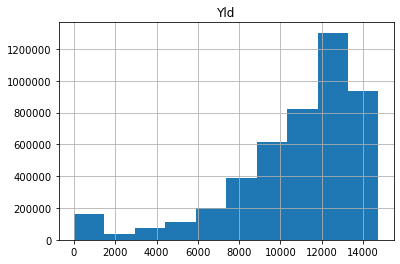

In [15]:
ydf.hist('Yld')

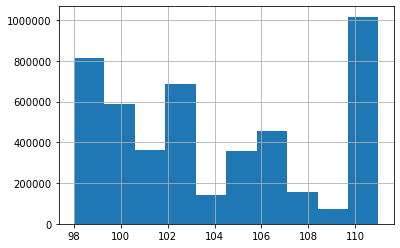

In [16]:
ydf.day_sow.hist()

In [17]:
S = soil_df.values
S_std = StandardScaler().fit(S)
S = S_std.transform(S)
dump(S_std, '../data/S_std.bin', compress=True)


['../data/S_std.bin']

In [18]:
Y_data = ydf.Yld.values.reshape(-1,1)
Y_std = StandardScaler().fit(Y_data)
Y = Y_std.transform(Y_data)
dump(Y_std, '../data/Y_std.bin', compress=True)
print(Y.shape)

(4651019, 1)


In [19]:
M_data = ydf.loc[:,cvars].values
M_std = StandardScaler().fit(M_data)
M = M_std.transform(M_data)
dump(M_std, '../data/M_std.bin', compress=True)
print(M.shape)

(4651019, 30)


In [20]:
Z = ydf.year_id.values.reshape(-1,1)
gss = GroupShuffleSplit(n_splits=1, test_size=0.1, train_size= 0.9, random_state=123456)
xidx = np.arange(len(ydf))
train_idx, val_idx = next(gss.split(xidx, groups=Z))
train_idx.size, val_idx.size

(4178228, 472791)

In [21]:
ntrain_idx = np.random.choice(train_idx, size=train_idx.size//10, replace=False)
nval_idx = np.random.choice(val_idx, size=val_idx.size//10, replace=False)
ntrain_idx.size, nval_idx.size

(417822, 47279)

In [22]:
len(np.unique(Z[ntrain_idx])), len(np.unique(Z[nval_idx])),

(27, 3)

In [23]:
batch_size = 1000


pred_dataset = MyDataset(W, S, M, Y, df_id, xidx)
train_dataset = MyDataset(W, S, M, Y, df_id, ntrain_idx)
val_dataset = MyDataset(W, S, M, Y, df_id, nval_idx)


pred_loader = torch.utils.data.DataLoader(pred_dataset, batch_size=batch_size, drop_last=False, shuffle=False)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, drop_last=False, shuffle=True)

data_inputs = iter(train_loader).next()
print(len(train_loader))



418


In [24]:
d = 0.1
w_layers =  [[6,12,3,d],[12,15,5,d],[15,20,7,d],[20,25,5,d],[25,100,3,d]]
s_layers = [[121,64,d],[64,32,d],[32,16,d],[16,32,d]]
pred_layers = [[162,100,d],[100,50,d],[50,50,d], [50,25,d]]

model = MyNet(w_layers, s_layers, pred_layers)
model = model.to(device)
model.load_state_dict(torch.load('../data/model_v0.pth', map_location=device))
sm = summary(model, *data_inputs[:3], print_summary=True)

----------------------------------------------------------------------------
           Layer (type)        Output Shape         Param #     Tr. Param #
               Conv1d-1     [1000, 12, 298]             228             228
            AvgPool1d-2     [1000, 12, 149]               0               0
            LeakyReLU-3     [1000, 12, 149]               0               0
          BatchNorm1d-4     [1000, 12, 149]              24              24
              Dropout-5     [1000, 12, 149]               0               0
               Conv1d-6     [1000, 15, 145]             915             915
            AvgPool1d-7      [1000, 15, 72]               0               0
            LeakyReLU-8      [1000, 15, 72]               0               0
          BatchNorm1d-9      [1000, 15, 72]              30              30
             Dropout-10      [1000, 15, 72]               0               0
              Conv1d-11      [1000, 20, 66]           2,120           2,120
           

In [25]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
min_loss = 10
bad_epochs = 0
liveloss = PlotLosses()
num_epochs = 150 # Define o número de épocas para realizar o treinamento 
for epoch in range(num_epochs):
    start_time = time.time()
    epoch_loss = []
    val_loss = []
    
    model.train()
    for i, (Ws, Ss, Ms, Ys) in enumerate(tqdm(train_loader)):
        
        # Limpa os gradientes
        optimizer.zero_grad()
    
        # Obtem o output
        outputs = model(Ws, Ss, Ms)

        # Caulcula a perda pela loss function
        loss = criterion(outputs, Ys)

        # Obtem os gradientes
        loss.backward()

        # Atualiza os parâmetros
        optimizer.step()
        epoch_loss.append(loss.data.item())
        
    model.eval()
    for i, (Ws, Ss, Ms, Ys) in enumerate(tqdm(val_loader)):
        with torch.no_grad():
          # Obtem o output
          outputs = model(Ws, Ss, Ms)

        # Caulcula a perda pela loss function (MSE)
        loss = criterion(outputs, Ys)

        val_loss.append(loss.data.item())
        
    epoch_loss = np.array(epoch_loss).mean()
    val_loss = np.array(val_loss).mean()
    time_taken = time.time() - start_time
    
    if val_loss < min_loss:
        # Nome da pasta com o arquivo .pth salvando os pesos do modelo treinado
        model_file_name = '../data/model_v0.pth'
        torch.save(model.state_dict(), model_file_name)
        bad_epochs = 0
        min_loss = val_loss
    else:
        bad_epochs += 1
    
    if bad_epochs > 50:
        break

    liveloss.update({
        'log loss': epoch_loss,
        'val_log loss': val_loss
    })
    liveloss.draw() #Apresenta o gráfico log loss
    print('[%d:%d] loss: %.3f time:%.2f' % (bad_epochs, epoch, epoch_loss, time_taken))


In [ ]:
model.load_state_dict(torch.load('../data/model_v0.pth', map_location=device))
print('Model OK')

In [ ]:
# Inicia o tempo para contagem
start_time = time.time()

# Realiza a predição dos dados a partir do modelo treinado - Dados de validação
model.eval()
obs = []
preds = []
for i, (Ws, Ss, Ms, Ys) in enumerate(tqdm(train_loader)):
    obs.append(Ys.cpu().data.numpy())
    with torch.no_grad():
        pred = model(Ws, Ss, Ms)
    preds.append(pred.cpu().data.numpy())
obs = np.concatenate(obs)
preds = np.concatenate(preds)

# Faz a diferença para calcular o tempo           
time_taken = time.time() - start_time
# Apresenta o valor do tempo
print('time:%.2f' % (time_taken))

In [ ]:
model.eval()
b_loss = []
for (Ws, Ss, Ms, Ys) in tqdm(train_loader):
    w_loss = []
    for i in trange(300):
        v_loss = [i]
        for v in range(5):
            Wsw = Ws.clone()
            Wsw[:,v,(i-4):(i+3)] = 0
            with torch.no_grad():
                outputs = model(Wsw, Ss, Ms)
            loss = criterion(outputs, Ys)
            v_loss.append(loss.data.item())
        w_loss.append(v_loss)
    b_loss.append(np.array(w_loss))

In [ ]:
dap_err = np.stack(b_loss).mean(0)

In [ ]:
cls = ["interval","radn", "maxt", "mint", "rain", "dayl", "dap"]


In [ ]:
plt.figure(figsize=(20,10))
for i in range(1,6):
    plt.plot(dap_err.T[0], dap_err.T[i], label = cls[i])
plt.legend()


In [ ]:
x = Y_std.inverse_transform(preds.reshape(-1))
y = Y_std.inverse_transform(obs.reshape(-1))

ax = plt.axes()
ax.set_aspect('equal', 'datalim')

plt.scatter(x, y, 0.1, alpha=0.1)
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k-', color = 'r')
print(np.round(np.corrcoef(x, y, rowvar=False)[1,0],3))
plt.show()

In [ ]:
x.mean(), y.mean()